**Version based on ARDL_vb_v7**

**Modification**: 1) Forecast weights are calculated based on MAE, not MAPE. 2) Models' ranking is based on test set's MAE, not AIC. 3) CPI chain index has been removed from data. 4) delete calculation of rsquared and rsquared_adj (on test)

In [85]:
import os

import warnings                                  
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize      

from statsmodels.tsa.api import ARDL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

from itertools import product                    
from tqdm import tqdm_notebook

from pandas.io.excel import ExcelWriter 

## Monthly data

### Reading and cleaning monthly data

In [86]:
#df=pd.read_excel('C:/Users/BelyaevMA/Documents/Macro_research/MacroDS/data/v3/macro_ds_m_v4.xlsx', index_col=1 , parse_dates=['observation_date'])
df=pd.read_excel('C:/Users/UmurzakovSI/Desktop/Macro_modeling/Code/ARDL/macro_dataset_q.xlsx', index_col=1)
df.index = pd.PeriodIndex(df.index, freq='Q').to_timestamp()
df = df.drop(['Unnamed: 0'], axis=1)
print(df.shape)

(56, 12)


In [87]:
df.tail()

,key_rate,IMOEX,RTSI,USDRUB,EURRUB,BRENT,RUSGAS,PPI_EA_M,DBT_UNP_M,NET_EXP,OVR_DEBT,Nom_GDP
YQ,,,,,,,,,,,,
2020-10-01,4.250000,3029.063333,1245.343333,76.239907,90.834954,45.616667,5.196667,100.933333,3022.366667,24.9,0.079378,28491.831061
2021-01-01,4.276882,3388.480000,1418.893333,74.368808,89.631049,61.850000,6.520000,103.500000,3186.733333,28.6,0.077696,29765.119781
2021-04-01,4.950000,3702.493333,1578.783333,74.255021,89.463949,70.566667,8.786667,102.633333,3238.900000,38.8,0.073695,31555.715874
2021-07-01,6.281183,3931.353333,1695.886667,73.466281,86.633520,75.946667,16.926667,101.033333,3240.700000,55.0,0.067824,33446.591223
2021-10-01,7.435484,3942.616667,1695.133333,72.639438,83.054894,77.576667,32.233333,101.300000,3215.733333,67.6,0.062620,35377.209458


In [88]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length=6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [89]:
# ADF test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "key_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6121
 No. Lags Chosen       = 1
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.0905. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IMOEX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.4306
 No. Lags Chosen       = 0
 Critical value 1%     = -3.555
 Critical value 5%     = -2.916
 Critical value 10%    = -2.596
 => P-Value = 0.9972. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "RTSI" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [90]:
#OVR_DEBT_SA test values in original format:
y_for_orig_test = df['OVR_DEBT'].copy(deep = True)

In [91]:
#ln for all columns
for col in df.columns:
    df[col] = np.log(df[col])

In [92]:
#first difference for all columns except CPI_M_CHI_SA, second diff for RUSGAS
for col in df.columns:
    df[col] = df[col].diff()

df['RUSGAS'] = df['RUSGAS'].diff()

df = df.drop([df.index[0], df.index[1]], axis=0)

In [93]:
# ADF test on each column
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "key_rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.331
 No. Lags Chosen       = 3
 Critical value 1%     = -3.568
 Critical value 5%     = -2.921
 Critical value 10%    = -2.599
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IMOEX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5252
 No. Lags Chosen       = 0
 Critical value 1%     = -3.56
 Critical value 5%     = -2.918
 Critical value 10%    = -2.597
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RTSI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [94]:
#Correlation Heatmap
def corrs(X_scaled):  
    """
        Parameters
        ----------
        X_scaled : df for  corr calculation

        Returns
        -------
        Show plt
    """
    plt.figure(figsize=(14,12))
    sns.heatmap(X_scaled.corr(),linewidths=0.1,vmax=1.0, 
                square=True,  linecolor='white', annot=True)
    return plt.show()

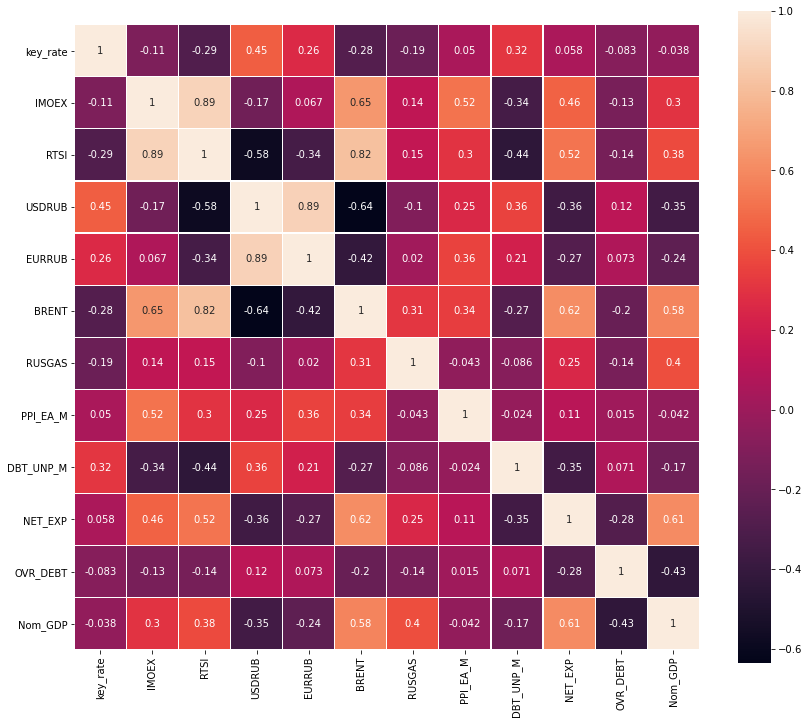

In [95]:
corrs(df)

### Train-test split (in transformed format)

In [96]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [97]:
df = swap_columns(df, 'Nom_GDP', 'OVR_DEBT')

In [98]:
y = df['OVR_DEBT'] #after transformation
X = df.iloc[:, 0:df.columns.get_loc('OVR_DEBT')]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False) # test_size = 0.3 (?)

In [99]:
df.head()

,key_rate,IMOEX,RTSI,USDRUB,EURRUB,BRENT,RUSGAS,PPI_EA_M,DBT_UNP_M,NET_EXP,Nom_GDP,OVR_DEBT
YQ,,,,,,,,,,,,
2008-07-01,0.046520,-0.322649,-0.355709,0.026391,-0.012110,-0.119751,0.032084,-0.039438,0.069638,0.005842,0.051408,0.034705
2008-10-01,0.087011,-0.679371,-0.849385,0.117463,-0.012922,-0.715404,-0.090456,-0.080985,0.097343,-0.668218,-0.066211,0.432051
2009-01-01,0.080043,0.050211,-0.153799,0.229600,0.214494,-0.150285,-0.350694,0.093539,0.015341,-0.272644,-0.114672,0.476856
2009-04-01,-0.052644,0.379105,0.496731,-0.063431,-0.018815,0.271685,-0.101618,0.001968,0.027288,0.076592,0.038634,0.419988
2009-07-01,-0.122015,0.103020,0.138241,-0.027503,0.022041,0.125404,0.208461,-0.002625,-0.021370,0.472305,0.050165,0.275062


### De-difference (inverse data transformation for diff(ln()))

In [100]:
def n_beg(ts):
    """
        Define index for first non Nan value in series
    """
    n_begin = ts.index[0]
    for i in range(len(ts)):
        if math.isnan(ts[i]):
            continue
        else:
            n_begin = ts.index[i]
            break
    return n_begin

In [101]:
def inverse_transformation(pred, test_y = y_for_orig_test):
    """
        Monthly iteration for predictions' series. Recalculation uses one point (with index t-1) of the original series (test_y)
        
        Input: First differencies series
        
        Output: Prediction series with original meaning. Length = 1 + length of input series
    """

    #Search for first number
    n_index = n_beg(pred)
    
    beg_ind = n_index-relativedelta(months=3)
    rng = pd.date_range(start=beg_ind, end=pred.index[len(pred)-1], freq="QS")
    ts = pd.Series(0, index=rng)
    
    y_0 = test_y.loc[beg_ind]
    ts.loc[beg_ind] = np.log(y_0)
    
    i = 0
    while (n_index+relativedelta(months=i) <= ts.index[len(ts)-1]):
        ts.loc[n_index+relativedelta(months=i)] = ts.loc[n_index+relativedelta(months=i-3)] + pred.loc[n_index+relativedelta(months=i)]
        i += 3
    
    return np.exp(ts)

### ARDL optimization

In [102]:
# GENERATION
# parameters for ARDL optimization
max_k = 3
var_number = 10000 #100000 # 1000 models -> 3 min
parameters_list = []
for i in range(var_number):
    list1 = np.random.randint(0,max_k+1, len(X.columns)+1).tolist()
    parameters_list.append(list1)

print(f'Total number of combinations = %i' %(len(parameters_list)))

Total number of combinations = 10000


In [103]:
parameters_list

[[0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 0, 3],
 [1, 3, 3, 0, 1, 0, 0, 1, 3, 2, 0, 2],
 [2, 2, 1, 0, 1, 2, 0, 1, 1, 3, 3, 0],
 [3, 0, 3, 1, 0, 0, 2, 0, 3, 0, 0, 2],
 [2, 1, 3, 1, 3, 3, 1, 1, 3, 0, 3, 0],
 [0, 0, 0, 0, 2, 1, 1, 0, 3, 1, 2, 2],
 [1, 2, 1, 1, 3, 0, 0, 2, 1, 3, 0, 0],
 [0, 0, 3, 3, 2, 3, 1, 0, 2, 0, 1, 1],
 [1, 1, 3, 3, 3, 3, 3, 2, 1, 2, 1, 3],
 [0, 1, 1, 3, 1, 1, 3, 2, 3, 3, 1, 1],
 [3, 0, 3, 3, 3, 1, 1, 2, 2, 3, 3, 2],
 [2, 0, 3, 2, 1, 2, 2, 3, 0, 3, 2, 2],
 [1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 2, 0],
 [2, 0, 2, 1, 3, 3, 3, 2, 3, 0, 2, 0],
 [3, 2, 2, 3, 2, 0, 0, 1, 3, 1, 1, 1],
 [3, 2, 2, 0, 0, 1, 0, 3, 3, 0, 0, 0],
 [1, 3, 1, 1, 0, 1, 0, 2, 3, 2, 3, 0],
 [1, 2, 0, 1, 3, 1, 1, 0, 0, 1, 1, 1],
 [2, 3, 2, 0, 2, 0, 3, 3, 1, 3, 3, 3],
 [3, 0, 3, 3, 2, 3, 3, 3, 1, 2, 1, 2],
 [0, 3, 3, 1, 0, 0, 2, 1, 0, 2, 0, 1],
 [1, 1, 3, 2, 3, 1, 3, 2, 3, 2, 0, 0],
 [1, 0, 2, 0, 1, 0, 2, 2, 1, 0, 2, 0],
 [2, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1],
 [2, 0, 0, 0, 2, 0, 3, 2, 2, 0, 2, 3],
 [1, 3, 3, 3, 3, 3, 3, 3,

In [104]:
#OPRIMIZATION FUNCTION
def optimizeARDL(X_train, X_test, y_train, y_test, parameters_list):
    """
        Return dataframe with parameters and corresponding metrics
    """
    
    results = []
    best_aic = float("inf")
    r_2 = float(-1)
    
    for param in tqdm_notebook(parameters_list):            
        try:
            lags = { "key_rate": param[1], "IMOEX": param[2], "RTSI": param[3], "USDRUB": param[4], "EURRUB": param[5], "BRENT": param[6], "RUSGAS": param[7], "PPI_EA_M": param[8], "DBT_UNP_M": param[9], "NET_EXP": param[10], "Nom_GDP": param[11]}
            model = ARDL(y_train, param[0], X_train, lags).fit()
        except:
            continue
              
        aic = model.aic
                
        pred = model.predict() #in-sample prediction
        n_begin = n_beg(pred)
        
        #metrics calculated on transformed data
        r_2_train = r2_score(y_train[n_begin:], pred[n_begin:])
        r_2_train_adj = 1-(1-r_2_train)*(X_train.shape[0]-1)/(X_train.shape[0]-sum(param)-1)

        
        
        pred_orig = inverse_transformation(pred)
        
        #metrics calculated on original data
        
        y_train_check = inverse_transformation(y_train)[n_beg(pred_orig):]
        in_mae = mae(y_train_check, pred_orig[n_beg(pred_orig):])
        in_mape = mape(y_train_check, pred_orig[n_beg(pred_orig):])
        
        try:
            forecast = inverse_transformation(model.forecast(len(y_test), X_test))
            out_mae = mae(y_for_orig_test[n_beg(forecast):], forecast)
            out_mape = mape(y_for_orig_test[n_beg(forecast):], forecast)  
        except:
            continue

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic, r_2_train, r_2_train_adj, in_mae, out_mae, in_mape, out_mape])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'r2', 'r2_adj', 'in_sample_mae', 'out_sample_mae', 'in_sample_mape', 'out_sample_mape']
    result_table = result_table.sort_values(by='out_sample_mae', ascending=True).reset_index(drop=True)
    
    return result_table

In [105]:
result_table = optimizeARDL(X_train, X_test, y_train, y_test, parameters_list)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
result_table.head(10)

,parameters,aic,r2,r2_adj,in_sample_mae,out_sample_mae,in_sample_mape,out_sample_mape
0,"[1, 3, 1, 3, 0, 1, 2, 0, 0, 0, 1, 0]",-153.061163,0.942796,0.919915,0.003037,0.002434,0.052773,0.032152
1,"[3, 1, 1, 3, 1, 0, 1, 0, 1, 1, 0, 3]",-162.097767,0.970624,0.954304,0.001074,0.002630,0.018578,0.034916
2,"[1, 1, 1, 3, 0, 2, 0, 0, 1, 0, 1, 2]",-153.606148,0.943534,0.920947,0.002036,0.002695,0.034230,0.035954
3,"[3, 3, 1, 0, 3, 0, 0, 0, 2, 0, 0, 1]",-149.033180,0.954994,0.934819,0.001856,0.002828,0.030355,0.037641
4,"[1, 3, 2, 2, 1, 1, 1, 0, 0, 0, 2, 2]",-159.926592,0.957889,0.934495,0.001813,0.003175,0.030021,0.043756
5,"[2, 0, 0, 1, 2, 1, 1, 0, 3, 0, 0, 1]",-148.959065,0.942405,0.921968,0.002093,0.003240,0.034908,0.043202
6,"[1, 3, 2, 1, 1, 0, 3, 0, 1, 0, 2, 1]",-153.378087,0.950784,0.923442,0.002372,0.003246,0.039584,0.044902
7,"[3, 3, 1, 2, 0, 0, 3, 0, 0, 1, 2, 2]",-158.520149,0.970933,0.951167,0.001069,0.003277,0.018061,0.042630
8,"[1, 2, 2, 0, 1, 3, 2, 3, 0, 0, 3, 2]",-153.578624,0.959514,0.926068,0.001547,0.003399,0.025889,0.046925
9,"[2, 0, 1, 1, 0, 3, 1, 3, 2, 0, 0, 2]",-139.501645,0.940321,0.907166,0.001717,0.003406,0.029494,0.044303


In [106]:
result_table.to_excel('C:/Users/UmurzakovSI/Desktop/Macro_modeling/Code/ARDL/ardl_res_1006_R^2_qtq_v2.xlsx')

In [107]:
def ardl_pred(X_train, X_test, y_train, y_test, N = 0, gr = True, summary = True, y = y_for_orig_test, table = result_table):
    """
        Build best model's in-sample and out-of-sample forecast and plot it. Forecasts are presented in original form
        
        N - number of model in result_table (N=0 - the best model according to AIC)
    """
    b_lags = { "key_rate": table.parameters[N][1], "IMOEX": table.parameters[N][2], "RTSI": table.parameters[N][3], "USDRUB": table.parameters[N][4], "EURRUB": table.parameters[N][5], "BRENT": table.parameters[N][6], "RUSGAS": table.parameters[N][7], "PPI_EA_M": table.parameters[N][8], "DBT_UNP_M": table.parameters[N][9], "NET_EXP": table.parameters[N][10], "Nom_GDP": table.parameters[N][11]}
    best_model = ARDL(y_train, table.parameters[N][0], X_train, b_lags).fit()
    #print(best_model.summary())
    
    pred = inverse_transformation(best_model.predict()) #in-sample prediction
    forec = inverse_transformation(best_model.forecast(len(y_test), X_test))
    
    if gr:
        plt.figure(figsize=(15, 7))
        plt.title("ARDL on single model")
        plt.plot(pred, color='g', label="model_on_train")
        plt.plot(forec, color='r', label="model_on_test")
        plt.plot(y, label="actual")
        plt.legend()
        plt.grid(True);
    
    if summary:
        print(best_model.summary())
    return pred, forec

                                         ARDL Model Results                                         
Dep. Variable:                                     OVR_DEBT   No. Observations:                   37
Model:             ARDL(3, 1, 2, 0, 3, 0, 0, 0, 1, 2, 1, 3)   Log Likelihood                  96.508
Method:                                     Conditional MLE   S.D. of innovations              0.014
Date:                                      Fri, 10 Jun 2022   AIC                           -135.016
Time:                                              18:13:33   BIC                            -90.751
Sample:                                          04-01-2009   HQIC                          -119.920
                                               - 07-01-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0243      0

(2009-01-01    0.026402
 2009-04-01    0.039882
 2009-07-01    0.052528
 2009-10-01    0.059508
 2010-01-01    0.061387
 2010-04-01    0.066531
 2010-07-01    0.065855
 2010-10-01    0.062894
 2011-01-01    0.058590
 2011-04-01    0.055329
 2011-07-01    0.053838
 2011-10-01    0.052055
 2012-01-01    0.051095
 2012-04-01    0.051064
 2012-07-01    0.049247
 2012-10-01    0.049815
 2013-01-01    0.048365
 2013-04-01    0.048628
 2013-07-01    0.046032
 2013-10-01    0.044540
 2014-01-01    0.043078
 2014-04-01    0.044450
 2014-07-01    0.045072
 2014-10-01    0.043842
 2015-01-01    0.045598
 2015-04-01    0.055800
 2015-07-01    0.061219
 2015-10-01    0.061610
 2016-01-01    0.065481
 2016-04-01    0.068417
 2016-07-01    0.069960
 2016-10-01    0.068155
 2017-01-01    0.066856
 2017-04-01    0.069087
 2017-07-01    0.068311
 Freq: QS-JAN, dtype: float64,
 2017-07-01    0.068311
 2017-10-01    0.066349
 2018-01-01    0.065646
 2018-04-01    0.068675
 2018-07-01    0.069621
 2018-10-

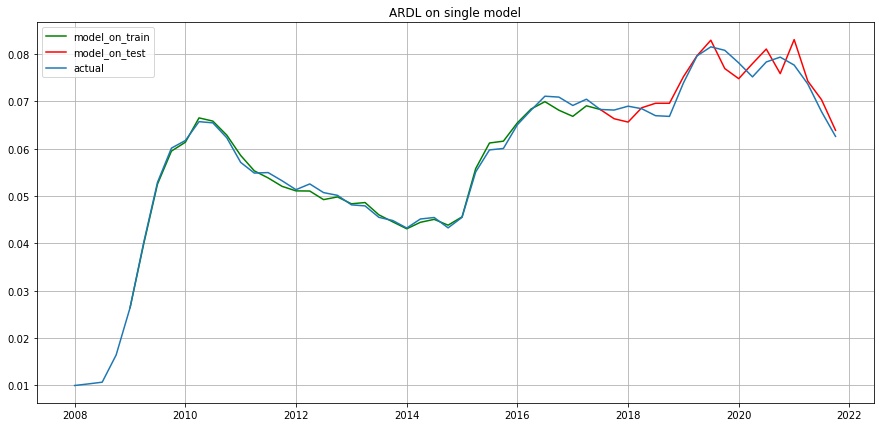

In [108]:
ardl_pred(X_train, X_test, y_train, y_test)

In [109]:
def weighted_forec(X_train, X_test, y_train, y_test, y = y_for_orig_test, k = 10, table = result_table, gr=True):
    """
        Build weighted forecast (k=10 best models according to test sample MAE). Weight is defined as (1/MAE_i)/(1/sum(MAE_i))
        
    """
    y_weighted, y_pred_weighted = [], []
    inv_sum_in, inv_sum_out = 0, 0
    for i in range(k):     
        inv_sum_out += 1/table['out_sample_mae'][i]
        inv_sum_in += 1/table['in_sample_mae'][i]
        
    for j in range(k):
        pred = ardl_pred(X_train, X_test, y_train, y_test, N = j, gr=False, summary=False)[0]
        forec = ardl_pred(X_train, X_test, y_train, y_test, N = j, gr=False, summary=False)[1]
        y_pred_weighted.append(pred*(1/table['in_sample_mae'][j]/inv_sum_in))
        y_weighted.append(forec*(1/table['out_sample_mae'][j]/inv_sum_out))
    
    y_pred = y_pred_weighted[0]
    for i in range(1, len(y_pred_weighted)):
        y_pred += y_pred_weighted[i]
        
    y_forecast = y_weighted[0]
    for i in range(1, len(y_weighted)):
        y_forecast += y_weighted[i]
        
    mod_mape_in = mape(y[n_beg(y_pred):n_beg(y_forecast)], y_pred)    
    mod_mape_out = mape(y[n_beg(y_forecast):], y_forecast)
    
    if gr:
        plt.figure(figsize=(15, 7))
        plt.title("ARDL-weighted model")
        plt.plot(y_pred, color='g', label="model_on_train")
        plt.plot(y_forecast, color='r', label="model_on_test")
        plt.plot(y, label="actual")
        plt.legend()
        plt.grid(True);
    
        
    return y_pred, mod_mape_in, y_forecast, mod_mape_out

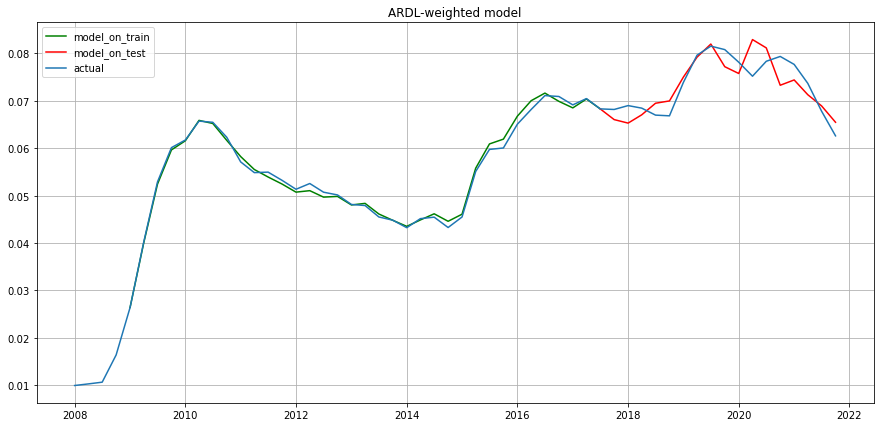

In [110]:
# top-10 models according to test sample MAE
#1000 combinations
mod1 = weighted_forec(X_train, X_test, y_train, y_test)

In [114]:
mod1[1]

0.012222161970897184

In [115]:
mod1[3]

0.03188670057913997

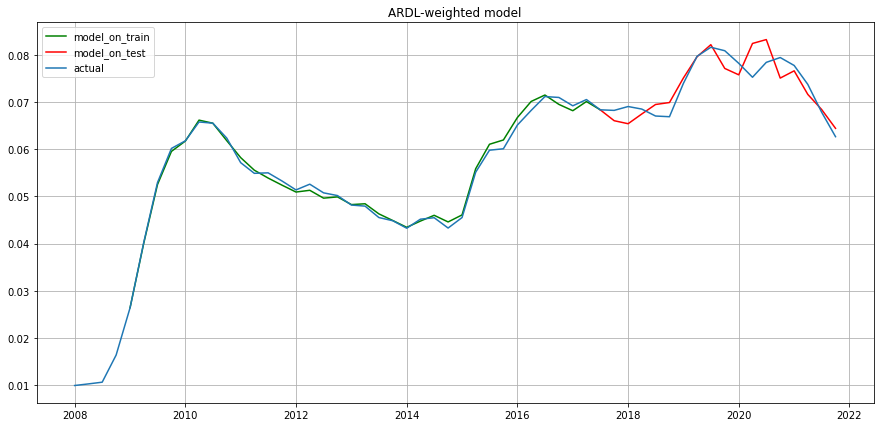

In [113]:
# top-10 models according to test sample MAE
#1000 combinations
mod1 = weighted_forec(X_train, X_test, y_train, y_test, k=5)

In [116]:
mod1[1]

0.012222161970897184

In [117]:
mod1[3]

0.03188670057913997

In [118]:
56/5

11.2

In [119]:
56/100*30

16.8